# Import Libraries

In [ ]:
## install pyportfolio (Min-Var Portfolio Allocation)
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.8 MB/s 
     |████████████████████████████████| 2.8 MB 11.5 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-frfdfra9
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-frfdfra9
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-il8qnjro/pyfolio_d00b629416874344b3273f00c6a77205
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-il8qnjro/pyfolio_d00b629416874344b3273f00c6a77205
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-il8qnjro/elegantrl_b92a89553ea442d5ac0d9149e261b601
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-il8qnjro/elegantrl_b92a89553ea442d5ac0d9149e261b601
     |████████████████████████████████| 73 kB 1.8 MB/s 
     |████████████████████████████████| 174 kB 34.6 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 43.2 MB/s 
     |██████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
matplotlib.use('Agg')
%matplotlib inline
import datetime

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading_stoploss import StockTradingEnvStopLoss
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



# Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Functions

## Stock Trading Stop Loss Environment

In [ ]:
import random
import time
from copy import deepcopy

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3.common import utils
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

matplotlib.use("Agg")

class StockTradingEnvStopLoss(gym.Env):
    """
    A stock trading environment for OpenAI gym
    This environment penalizes the model if excedeed the stop-loss threshold, selling assets with under expectation %profit, and also for not maintaining a reserve of cash.
    This enables the model to do trading with high confidence and manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) + additional_reward - total_penalty - initial_cash) / initial_cash / days_elapsed
        where total_penalty = cash_penalty + stop_loss_penalty + low_profit_penalty
                cash_penalty = max(0, sum(cash, asset_value)*cash_penalty_proportion-cash)
                stop_loss_penalty = -1 * dot(holdings,negative_closing_diff_avg_buy)
                low_profit_penalty = -1 * dot(holdings,negative_profit_sell_diff_avg_buy)
                additional_reward = dot(holdings,positive_profit_sell_diff_avg_buy)
        This reward function takes into account a profit/loss ratio constraint, liquidity requirement, as well as long-term accrued rewards.
        This reward function also forces the model to trade only when it's really confident to do so.
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>},}
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int): max number of share purchases allowed per asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares can be bought in each trade.
        stoploss_penalty (float): Maximum loss we can tolerate. Valid value range is between 0 and 1. If x is specified, then agent will force sell all holdings for a particular asset if current price < x * avg_buy_price
        profit_loss_ratio (int, float): Expected profit/loss ratio. Only applicable when stoploss_penalty < 1.
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. It could be OHLC columns or any other variables such as technical indicators and turbulence index
        cash_penalty_proportion (int, float): Penalty to apply if the algorithm runs out of cash
        patient (bool): option to choose whether end the cycle when we're running out of cash or just don't buy anything until we got additional cash
    action space: <share_dollar_purchases>
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        buy_cost_pct=3e-3,
        sell_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        discrete_actions=False,
        shares_increment=1,
        stoploss_penalty=0.9,
        profit_loss_ratio=2,
        turbulence_threshold=None,
        print_verbosity=10,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        cache_indicator_data=True,
        cash_penalty_proportion=0.1,
        random_start=True,
        patient=False,
        currency="$",
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start
        self.discrete_actions = discrete_actions
        self.patient = patient
        self.currency = currency
        self.df = self.df.set_index(date_col_name)
        self.shares_increment = shares_increment
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.stoploss_penalty = stoploss_penalty
        self.min_profit_penalty = 1 + profit_loss_ratio * (1 - self.stoploss_penalty)
        self.turbulence_threshold = turbulence_threshold
        self.daily_information_cols = daily_information_cols
        self.state_space = (1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols))
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))
        self.turbulence = 0
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)

    @property
    def current_step(self):
        return self.date_index - self.starting_point

    def reset(self):
        self.seed()
        self.sum_trades = 0
        self.actual_num_trades = 0
        self.closing_diff_avg_buy = np.zeros(len(self.assets))
        self.profit_sell_diff_avg_buy = np.zeros(len(self.assets))
        self.n_buys = np.zeros(len(self.assets))
        self.avg_buy_price = np.zeros(len(self.assets))
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates) * 0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.turbulence = 0
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {"cash": [],
                                    "asset_value": [],
                                    "total_assets": [],
                                    "reward": [],}
        init_state = np.array([self.initial_amount] + [0] * len(self.assets) + self.get_date_vector(self.date_index))
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[[date]]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v

    def return_terminal(self, reason="Last Date", reward=0):
        state = self.state_memory[-1]
        self.log_step(reason=reason, terminal_reward=reward)
        # add outputs to logger interface
        self.logger = utils.configure_logger()
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        self.logger.record("environment/GainLoss_pct", (gl_pct - 1) * 100)
        self.logger.record("environment/total_assets", int(self.account_information["total_assets"][-1]),)
        reward_pct = self.account_information["total_assets"][-1] / self.initial_amount
        self.logger.record("environment/total_reward_pct", (reward_pct - 1) * 100)
        self.logger.record("environment/total_trades", self.sum_trades)
        self.logger.record("environment/actual_num_trades", self.actual_num_trades,)
        self.logger.record("environment/avg_daily_trades", self.sum_trades / (self.current_step),)
        self.logger.record("environment/avg_daily_trades_per_asset", self.sum_trades / (self.current_step) / len(self.assets),)
        self.logger.record("environment/completed_steps", self.current_step)
        self.logger.record("environment/sum_rewards", np.sum(self.account_information["reward"]))
        self.logger.record("environment/cash_proportion", self.account_information["cash"][-1] / self.account_information["total_assets"][-1],)
        return state, reward, True, {}

    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information["reward"][-1]
        cash_pct = (self.account_information["cash"][-1] / self.account_information["total_assets"][-1])
        gl_pct = self.account_information["total_assets"][-1] / self.initial_amount
        rec = [self.episode,
               self.date_index - self.starting_point,
               reason,
               f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['cash'][-1]))}",
               f"{self.currency}{'{:0,.0f}'.format(float(self.account_information['total_assets'][-1]))}",
               f"{terminal_reward*100:0.5f}%",
               f"{(gl_pct - 1)*100:0.5f}%",
               f"{cash_pct*100:0.2f}%",]
        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def log_header(self):
        self.template = "{0:4}|{1:4}|{2:15}|{3:15}|{4:15}|{5:10}|{6:10}|{7:10}"  # column widths: 8, 10, 15, 7, 10
        print(self.template.format("EPISODE",
                                   "STEPS",
                                   "TERMINAL_REASON",
                                   "CASH",
                                   "TOT_ASSETS",
                                   "TERMINAL_REWARD_unsc",
                                   "GAINLOSS_PCT",
                                   "CASH_PROPORTION",))
        self.printed_header = True

    def get_reward(self):
        if self.current_step == 0:
            return 0
        else:
            total_assets = self.account_information["total_assets"][-1]
            cash = self.account_information["cash"][-1]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            neg_closing_diff_avg_buy = np.clip(self.closing_diff_avg_buy, -np.inf, 0)
            neg_profit_sell_diff_avg_buy = np.clip(self.profit_sell_diff_avg_buy, -np.inf, 0)
            pos_profit_sell_diff_avg_buy = np.clip(self.profit_sell_diff_avg_buy, 0, np.inf)
            cash_penalty = max(0, (total_assets * self.cash_penalty_proportion - cash))
            if self.current_step > 1:
                prev_holdings = self.state_memory[-2][1 : len(self.assets) + 1]
                stop_loss_penalty = -1 * np.dot(np.array(prev_holdings), neg_closing_diff_avg_buy)
            else:
                stop_loss_penalty = 0
            low_profit_penalty = -1 * np.dot(np.array(holdings), neg_profit_sell_diff_avg_buy)
            total_penalty = cash_penalty + stop_loss_penalty + low_profit_penalty
            additional_reward = np.dot(np.array(holdings), pos_profit_sell_diff_avg_buy)
            reward = ((total_assets - total_penalty + additional_reward) / self.initial_amount) - 1
            reward /= self.current_step
            return reward

    def step(self, actions):
        # let's just log what we're doing in terms of max actions at each step
        self.sum_trades += np.sum(np.abs(actions))
        # print header only first time
        if self.printed_header is False:
            self.log_header()
        # print if it's time
        if (self.current_step + 1) % self.print_verbosity == 0:
            self.log_step(reason="update")
        # if we're at the end
        if self.date_index == len(self.dates) - 1:
            # if we hit the end, set reward to total gains (or losses)
            return self.return_terminal(reward=self.get_reward())
        else:
            # compute value of cash + assets
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert min(holdings) >= 0
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))
            asset_value = np.dot(holdings, closings)
            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            reward = self.get_reward()
            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information["reward"].append(reward)
            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions * closings)  # capture what the model's trying to do
            # buy/sell only if the price is > 0 (no missing data in this particular date)
            actions = np.where(closings > 0, actions, 0)
            if self.turbulence_threshold is not None:
                # if turbulence goes over threshold, just clear out all positions
                if self.turbulence >= self.turbulence_threshold:
                    actions = -(np.array(holdings) * closings)
                    self.log_step(reason="TURBULENCE")
            # scale cash purchases to asset
            if self.discrete_actions:
                # convert into integer because we can't buy fraction of shares
                actions = np.where(closings > 0, actions // closings, 0)
                actions = actions.astype(int)
                # round down actions to the nearest multiplies of shares_increment
                actions = np.where(actions >= 0,
                                   (actions // self.shares_increment) * self.shares_increment,
                                   ((actions + self.shares_increment) // self.shares_increment)* self.shares_increment,)
            else:
                actions = np.where(closings > 0, actions / closings, 0)
            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))
            self.closing_diff_avg_buy = closings - (self.stoploss_penalty * self.avg_buy_price)
            if begin_cash >= self.stoploss_penalty * self.initial_amount:
                # clear out position if stop-loss criteria is met
                actions = np.where(self.closing_diff_avg_buy < 0, -np.array(holdings), actions)
                if any(np.clip(self.closing_diff_avg_buy, -np.inf, 0) < 0):
                    self.log_step(reason="STOP LOSS")
            # compute our proceeds from sells, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.sell_cost_pct
            coh = begin_cash + proceeds
            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.buy_cost_pct
            # if we run out of cash...
            if (spend + costs) > coh:
                if self.patient:
                    # ... just don't buy anything until we got additional cash
                    self.log_step(reason="CASH SHORTAGE")
                    actions = np.where(actions > 0, 0, actions)
                    spend = 0
                    costs = 0
                else:
                    # ... end the cycle and penalize
                    return self.return_terminal(reason="CASH SHORTAGE", reward=self.get_reward())
            
            self.transaction_memory.append(actions)  # capture what the model's could do
            
            # get profitable sell actions
            sell_closing_price = np.where(sells > 0, closings, 0)  # get closing price of assets that we sold
            profit_sell = np.where(sell_closing_price - self.avg_buy_price > 0, 1, 0)  # mark the one which is profitable
            self.profit_sell_diff_avg_buy = np.where(profit_sell == 1, closings - (self.min_profit_penalty * self.avg_buy_price),0,)
            if any(np.clip(self.profit_sell_diff_avg_buy, -np.inf, 0) < 0):
                self.log_step(reason="LOW PROFIT")
            else:
                if any(np.clip(self.profit_sell_diff_avg_buy, 0, np.inf) > 0):
                    self.log_step(reason="HIGH PROFIT")

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # log actual total trades we did up to current step
            self.actual_num_trades = np.sum(np.abs(np.sign(actions)))

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions

            # update average buy price
            buys = np.sign(buys)
            self.n_buys += buys
            self.avg_buy_price = np.where(buys > 0, self.avg_buy_price + ((closings - self.avg_buy_price) / self.n_buys), self.avg_buy_price,)  # incremental average

            # set as zero when we don't have any holdings anymore
            self.n_buys = np.where(holdings_updated > 0, self.n_buys, 0)
            self.avg_buy_price = np.where(holdings_updated > 0, self.avg_buy_price, 0)
            self.date_index += 1
            if self.turbulence_threshold is not None:
                self.turbulence = self.get_date_vector(self.date_index, cols=["turbulence"])[0]

            # update state
            state = ([coh] + list(holdings_updated) + self.get_date_vector(self.date_index))
            self.state_memory.append(state)
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)
        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs

    def get_multiproc_env(self, n=10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method="fork")
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step == 0:
            return None
        else:
            self.account_information["date"] = self.dates[ -len(self.account_information["cash"]) :]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step == 0:
            return None
        else:
            return pd.DataFrame({"date": self.dates[-len(self.account_information["cash"]) :],
                                 "actions": self.actions_memory,
                                 "transactions": self.transaction_memory,})

## Stable Baselines 3 DRL Models & Agents

In [ ]:
import time

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (NormalActionNoise, OrnsteinUhlenbeckActionNoise,)
from stable_baselines3.common.vec_env import DummyVecEnv

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {"normal": NormalActionNoise, "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,}

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True

class DRLAgent:
    """
    Provides implementations for DRL algorithms
    Attributes
    ----------
        env: gym environment class
            user-defined class
    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(self,
                  model_name,
                  policy="MlpPolicy",
                  policy_kwargs=None,
                  model_kwargs=None,
                  verbose=1,
                  seed=None,
                 ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]
        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        print(model_kwargs)
        model = MODELS[model_name](policy=policy,
                                   env=self.env,
                                   tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
                                   verbose=verbose,
                                   policy_kwargs=policy_kwargs,
                                   seed=seed,
                                   **model_kwargs,)
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps,
                            tb_log_name=tb_log_name,
                            callback=TensorboardCallback(),)
        return model

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """
        Make a prediction
        """
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")
        # test on the testing env
        state = environment.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(environment.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = environment.step(action)
            total_asset = (environment.amount + (environment.price_ary[environment.day] * environment.stocks).sum())
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)
        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets

# Download Data

In [ ]:
# DOW_30_TICKER
# NAS_100_TICKER
# SP_500_TICKER 

In [ ]:
# index constituents
print(config.NAS_100_TICKER)

['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MYL', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


In [ ]:
df = YahooDownloader(start_date = '2000-01-01',
                     end_date = '2021-11-01',
                     ticker_list = config.NAS_100_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df

date        open        high  ...       volume   tic  day
0       2000-01-03    0.936384    1.004464  ...  535796800.0  AAPL    0
1       2000-01-03   16.812500   16.875000  ...    7384400.0  ADBE    0
2       2000-01-03   46.750000   46.937500  ...    3655600.0   ADI    0
3       2000-01-03   42.428928   42.775894  ...    2698899.0   ADP    0
4       2000-01-03    8.500000    8.656250  ...    2845600.0  ADSK    0
...            ...         ...         ...  ...          ...   ...  ...
474526  2021-10-29   49.919998   53.500000  ...   18239400.0   WDC    4
474527  2021-10-29  246.990005  248.809998  ...    2288400.0  WLTW    4
474528  2021-10-29   90.650002   91.449997  ...    2957700.0  WYNN    4
474529  2021-10-29   65.519997   65.599998  ...    4082900.0   XEL    4
474530  2021-10-29  179.899994  182.339996  ...    1361800.0  XLNX    4

[474531 rows x 8 columns]

# Preprocess Data

In [ ]:
# technical indicators list
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
# add technical indicators, vix and turbulence
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5492, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

date        open        high  ...  close_60_sma        vix  turbulence
0       2000-01-03    0.936384    1.004464  ...      0.856887  24.209999    0.000000
1       2000-01-03   16.812500   16.875000  ...     16.274672  24.209999    0.000000
2       2000-01-03   46.750000   46.937500  ...     29.667686  24.209999    0.000000
3       2000-01-03   42.428928   42.775894  ...     25.976393  24.209999    0.000000
4       2000-01-03    8.500000    8.656250  ...      8.052904  24.209999    0.000000
...            ...         ...         ...  ...           ...        ...         ...
362467  2021-10-28  181.190002  183.830002  ...    189.037501  16.530001  198.477121
362468  2021-10-28   47.080002   47.349998  ...     48.092658  16.530001  198.477121
362469  2021-10-28   55.860001   57.340000  ...     59.233333  16.530001  198.477121
362470  2021-10-28   63.080002   64.589996  ...     66.046343  16.530001  198.477121
362471  2021-10-28  184.289993  185.720001  ...    155.706698  16.530001  198.477121

[362472 rows x 18 columns]

In [ ]:
# data wrangling
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full

date   tic        open  ...  close_60_sma        vix  turbulence
0       2000-01-03  AAPL    0.936384  ...      0.856887  24.209999    0.000000
1       2000-01-03  ADBE   16.812500  ...     16.274672  24.209999    0.000000
2       2000-01-03   ADI   46.750000  ...     29.667686  24.209999    0.000000
3       2000-01-03   ADP   42.428928  ...     25.976393  24.209999    0.000000
4       2000-01-03  ADSK    8.500000  ...      8.052904  24.209999    0.000000
...            ...   ...         ...  ...           ...        ...         ...
526015  2021-10-28  VRTX  181.190002  ...    189.037501  16.530001  198.477121
526016  2021-10-28   WBA   47.080002  ...     48.092658  16.530001  198.477121
526017  2021-10-28   WDC   55.860001  ...     59.233333  16.530001  198.477121
526018  2021-10-28   XEL   63.080002  ...     66.046343  16.530001  198.477121
526019  2021-10-28  XLNX  184.289993  ...    155.706698  16.530001  198.477121

[362472 rows x 18 columns]

In [ ]:
# set turbulance threshold
data_risk_indicator = processed_full[(processed_full.date<'2020-01-01') & (processed_full.date>='2000-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

# Multiple Stock Trading

## Design Environment

In [ ]:
train = data_split(processed_full, '2000-01-01','2020-01-01')
trade = data_split(processed_full, '2020-01-01','2021-10-01')
print(len(train))
print(len(trade))

332046
29106


In [ ]:
e_train_gym = StockTradingEnvStopLoss(df = train,
                                      initial_amount = 1000000,
                                      hmax = 100, 
                                      turbulence_threshold = None, 
                                      currency='$',
                                      buy_cost_pct=0.001,
                                      sell_cost_pct=0.001,
                                      stoploss_penalty=0.75,
                                      profit_loss_ratio=1.5,
                                      cash_penalty_proportion=0.05,
                                      cache_indicator_data=True,
                                      daily_information_cols = config.TECHNICAL_INDICATORS_LIST, 
                                      print_verbosity = 500, 
                                      random_start = True,
                                      patient=True)

e_trade_gym = StockTradingEnvStopLoss(df = trade,
                                      initial_amount = 1000000,
                                      hmax = 100, 
                                      turbulence_threshold = None, 
                                      currency='$',
                                      buy_cost_pct=0.001,
                                      sell_cost_pct=0.001,
                                      stoploss_penalty=0.75,
                                      profit_loss_ratio=1.5,
                                      cash_penalty_proportion=0.05,
                                      cache_indicator_data=True,
                                      daily_information_cols = config.TECHNICAL_INDICATORS_LIST, 
                                      print_verbosity = 500, 
                                      random_start = False,
                                      patient=True)

caching data
data cached!
caching data
data cached!


In [ ]:
env_train, _ = e_train_gym.get_sb_env()
env_trade, _ = e_trade_gym.get_sb_env()

## Implement DRL Algorithms

In [ ]:
# Model 1: A2C (Normal Env)
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [ ]:
model_a2c.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'a2c',
                n_eval_episodes = 1)
model_a2c.save("a2c.model")

Logging to tensorboard_log/a2c/a2c_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$997,761       |$1,000,168     |0.00000%  |0.01680%  |99.76%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$996,490       |$999,949       |0.00370%  |-0.00511% |99.65%    
   1|   3|LOW PROFIT     |$995,288       |$999,808       |-0.00390% |-0.01915% |99.55%    
   1|   4|LOW PROFIT     |$993,840       |$999,773       |-0.00544% |-0.02269% |99.41%    
--------------------------
| time/              |   |
|    fps             | 0 |
|    iterations      | 1 |
|    time_elapsed    | 5 |
|    total_timesteps | 5 |
--------------------------
   1|   5|STOP LOSS      |$992,694       |$999,256       |-0.00942% |-0.07441% |99.34%    
   1|   5|LOW PROFIT     |$992,694       |$999,256       |-0.00942% |-0.07441% |99.34%    
   1|   6|STOP LOSS      |$992,500       |$999,004       |-0.01451% |-0.09963% |99.35%    
   1|   7|LOW PROFIT     |$991,448       |$999,398       |-0.01428% |-0.06018% |99.20%    
   1|   8|LOW PROFIT     |$990,495       |$999,968       |-0.01302% |-0.00323% |99.05%    
   1|   9|LOW PROFIT     |$990,405       |$999,944       |-0.00848% |-0.00556% |99.

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
   7|  62|LOW PROFIT     |$962,655       |$996,791       |-0.00758% |-0.32089% |96.58%    
   7|  63|LOW PROFIT     |$963,152       |$997,428       |-0.00762% |-0.25725% |96.56%    
   7|  64|LOW PROFIT     |$963,188       |$997,377       |-0.00749% |-0.26231% |96.57%    
------------------------------------
| time/                 |          |
|    fps                | 5        |
|    iterations         | 4757     |
|    time_elapsed       | 3995     |
|    total_timesteps    | 23785    |
| train/                |          |
|    entropy_loss       | -288     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4756     |
|    policy_loss        | -0.0164  |
|    std                | 21.7     |
|    value_loss         | 3.72e-09 |
------------------------------------
   7|  65|LOW PROFIT     |$962,954       |$997,467       |-0.00679% |-0.25335% |96.54%    
   7|  66|LOW PROFIT     |$962

In [ ]:
# Model 2: PPO (Stop Loss Env)
agent = DRLAgent(env = env_train)
PPO_PARAMS = {"n_steps": 2048,
              "ent_coef": 0.01,
              "learning_rate": 0.00025,
              "batch_size": 64}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


In [ ]:
model_ppo.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'ppo',
                n_eval_episodes = 1)
model_ppo.save("ppo.model")

Logging to tensorboard_log/ppo/ppo_1
   8|   1|LOW PROFIT     |$998,100       |$1,000,000     |0.00000%  |0.00001%  |99.81%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   8|   2|LOW PROFIT     |$996,223       |$999,967       |-0.00141% |-0.00329% |99.63%    
   8|   3|LOW PROFIT     |$994,966       |$999,948       |-0.00426% |-0.00520% |99.50%    
   8|   4|LOW PROFIT     |$994,419       |$999,917       |-0.00498% |-0.00830% |99.45%    
   8|   5|LOW PROFIT     |$993,974       |$1,000,024     |-0.00490% |0.00238%  |99.40%    
   8|   6|LOW PROFIT     |$993,332       |$1,000,048     |-0.00851% |0.00483%  |99.33%    
   8|   7|LOW PROFIT     |$992,134       |$999,953       |-0.00740% |-0.00466% |99.22%    
   8|   8|LOW PROFIT     |$992,081       |$999,955       |-0.00625% |-0.00449% |99.21%    
   8|   9|LOW PROFIT     |$991,398       |$999,935       |-0.00409% |-0.00648% |99.15%    
   8|  10|LOW PROFIT     |$990,545       |$999,892       |-0.00573% |-0.01078% |99.07%    
   8|  11|LOW PROFIT     |$991,273       |$999,930       |-0.00427% |-0.00701% |99.13%    
   8|  12|LOW PROFIT     |$990,801       |$999,942       |-0.00505% |-0.00582% |99.09%    

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
  13|2569|LOW PROFIT     |$697,553       |$1,739,892     |0.03550%  |73.98916% |40.09%    
  13|2570|LOW PROFIT     |$696,982       |$1,747,896     |0.03423%  |74.78964% |39.88%    
  13|2571|LOW PROFIT     |$696,849       |$1,757,906     |0.03710%  |75.79057% |39.64%    
  13|2572|LOW PROFIT     |$696,442       |$1,764,683     |0.03286%  |76.46831% |39.47%    
  13|2573|LOW PROFIT     |$696,248       |$1,780,606     |0.03539%  |78.06060% |39.10%    
  13|2574|LOW PROFIT     |$696,271       |$1,778,520     |0.03657%  |77.85204% |39.15%    
  13|2575|LOW PROFIT     |$696,623       |$1,785,448     |0.03748%  |78.54483% |39.02%    
  13|2576|LOW PROFIT     |$695,896       |$1,782,885     |0.04064%  |78.28846% |39.03%    
  13|2577|LOW PROFIT     |$695,083       |$1,776,595     |0.03687%  |77.65951% |39.12%    
  13|2578|LOW PROFIT     |$693,875       |$1,780,442     |0.03803%  |78.04415% |38.97%    
  13|2579|LOW PROFIT     |$693,025     

In [ ]:
# Model 3: DDPG (Cash Penalty Env)
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
model_ddpg.learn(total_timesteps = 25000, 
                 eval_env = env_trade, 
                 eval_freq = 500,
                 log_interval = 1, 
                 tb_log_name = 'ddpg',
                 n_eval_episodes = 1)
model_ddpg.save("ddpg.model")

Logging to tensorboard_log/ddpg/ddpg_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$998,510       |$1,000,009     |0.00000%  |0.00093%  |99.85%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$997,623       |$999,942       |-0.00202% |-0.00577% |99.77%    
   1|   3|LOW PROFIT     |$996,366       |$999,925       |-0.00192% |-0.00748% |99.64%    
   1|   4|LOW PROFIT     |$995,143       |$999,804       |-0.00339% |-0.01958% |99.53%    
   1|   5|LOW PROFIT     |$994,827       |$999,850       |-0.00392% |-0.01503% |99.50%    
   1|   6|LOW PROFIT     |$994,607       |$999,894       |-0.00420% |-0.01064% |99.47%    
   1|   7|LOW PROFIT     |$994,393       |$999,881       |-0.00822% |-0.01188% |99.45%    
   1|   8|LOW PROFIT     |$994,144       |$999,999       |-0.00690% |-0.00011% |99.41%    
   1|   9|LOW PROFIT     |$993,286       |$1,000,033     |-0.00427% |0.00332%  |99.33%    
   1|  10|LOW PROFIT     |$992,675       |$1,000,247     |-0.00582% |0.02472%  |99.24%    
   1|  11|LOW PROFIT     |$992,444       |$1,000,301     |-0.00643% |0.03009%  |99.21%    
   1|  12|LOW PROFIT     |$991,302       |$1,000,328     |-0.00276% |0.03283%  |99.10%    

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
   8| 795|CASH SHORTAGE  |$2,076         |$1,498,003     |0.05912%  |49.80029% |0.14%     
   8| 795|HIGH PROFIT    |$2,076         |$1,498,003     |0.05912%  |49.80029% |0.14%     
   8| 796|CASH SHORTAGE  |$2,176         |$1,514,642     |0.05691%  |51.46421% |0.14%     
   8| 796|HIGH PROFIT    |$2,176         |$1,514,642     |0.05691%  |51.46421% |0.14%     
   8| 797|CASH SHORTAGE  |$2,276         |$1,513,127     |0.05944%  |51.31266% |0.15%     
   8| 797|HIGH PROFIT    |$2,276         |$1,513,127     |0.05944%  |51.31266% |0.15%     
   8| 798|CASH SHORTAGE  |$2,376         |$1,502,224     |0.05931%  |50.22238% |0.16%     
   8| 798|HIGH PROFIT    |$2,376         |$1,502,224     |0.05931%  |50.22238% |0.16%     
   8| 799|CASH SHORTAGE  |$2,476         |$1,519,719     |0.05790%  |51.97190% |0.16%     
   8| 799|HIGH PROFIT    |$2,476         |$1,519,719     |0.05790%  |51.97190% |0.16%     
   8| 800|CASH SHORTAGE  |$2,576       

In [ ]:
# Model 4: TD3 (Cash Penalty Env)
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 64, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}
model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
model_td3.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'td3',
                n_eval_episodes = 1)
model_td3.save("td3.model")

Logging to tensorboard_log/td3/td3_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$998,091       |$1,000,011     |0.00000%  |0.00114%  |99.81%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$997,209       |$1,000,116     |-0.00420% |0.01161%  |99.71%    
   1|   3|LOW PROFIT     |$996,679       |$1,000,135     |-0.00548% |0.01348%  |99.65%    
   1|   4|LOW PROFIT     |$995,413       |$1,000,148     |-0.00259% |0.01478%  |99.53%    
   1|   5|LOW PROFIT     |$994,404       |$1,000,132     |-0.00347% |0.01316%  |99.43%    
   1|   6|LOW PROFIT     |$993,693       |$1,000,243     |-0.00585% |0.02433%  |99.35%    
   1|   7|LOW PROFIT     |$994,261       |$1,000,078     |-0.00418% |0.00778%  |99.42%    
   1|   8|LOW PROFIT     |$993,000       |$1,000,079     |-0.00378% |0.00786%  |99.29%    
   1|   9|LOW PROFIT     |$993,047       |$1,000,188     |-0.00490% |0.01881%  |99.29%    
   1|  10|LOW PROFIT     |$992,729       |$1,000,370     |-0.00418% |0.03699%  |99.24%    
   1|  11|LOW PROFIT     |$992,444       |$1,000,389     |-0.00735% |0.03890%  |99.21%    
   1|  12|LOW PROFIT     |$991,516       |$1,000,167     |-0.00268% |0.01671%  |99.14%    

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
   6|2031|CASH SHORTAGE  |$1,458         |$4,511,142     |0.16101%  |351.11420%|0.03%     
   6|2032|CASH SHORTAGE  |$1,458         |$4,530,805     |0.16176%  |353.08051%|0.03%     
   6|2033|CASH SHORTAGE  |$1,458         |$4,570,420     |0.16260%  |357.04198%|0.03%     
   6|2034|CASH SHORTAGE  |$1,458         |$4,569,589     |0.16437%  |356.95890%|0.03%     
   6|2035|CASH SHORTAGE  |$1,458         |$4,573,420     |0.16425%  |357.34204%|0.03%     
   6|2036|CASH SHORTAGE  |$1,458         |$4,610,953     |0.16435%  |361.09529%|0.03%     
   6|2037|CASH SHORTAGE  |$1,458         |$4,603,524     |0.16602%  |360.35239%|0.03%     
   6|2038|CASH SHORTAGE  |$1,458         |$4,613,557     |0.16559%  |361.35573%|0.03%     
   6|2039|CASH SHORTAGE  |$1,458         |$4,644,638     |0.16598%  |364.46380%|0.03%     
   6|2040|CASH SHORTAGE  |$1,458         |$4,636,692     |0.16735%  |363.66919%|0.03%     
   6|2041|CASH SHORTAGE  |$1,458       

In [ ]:
# Model 5: SAC (Cash Penalty Env)
agent = DRLAgent(env = env_train)
SAC_PARAMS = {"batch_size": 64,
              "buffer_size": 1000000,
              "learning_rate": 0.0001,
              "learning_starts": 100,
              "ent_coef": "auto_0.1",}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 64, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [ ]:
model_sac.learn(total_timesteps = 25000, 
                eval_env = env_trade, 
                eval_freq = 500,
                log_interval = 1, 
                tb_log_name = 'sac',
                n_eval_episodes = 1)
model_sac.save("sac.model")

Logging to tensorboard_log/sac/sac_1
EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$998,331       |$999,986       |0.00000%  |-0.00142% |99.83%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$997,549       |$1,000,013     |-0.00161% |0.00128%  |99.75%    
   1|   3|LOW PROFIT     |$995,857       |$1,000,076     |-0.00234% |0.00762%  |99.58%    
   1|   4|LOW PROFIT     |$995,506       |$1,000,044     |-0.00557% |0.00445%  |99.55%    
   1|   5|LOW PROFIT     |$994,716       |$1,000,005     |-0.00966% |0.00050%  |99.47%    
   1|   6|LOW PROFIT     |$994,478       |$1,000,078     |-0.00372% |0.00783%  |99.44%    
   1|   7|LOW PROFIT     |$994,261       |$999,989       |-0.00807% |-0.00114% |99.43%    
   1|   8|LOW PROFIT     |$992,987       |$999,971       |-0.00193% |-0.00289% |99.30%    
   1|   9|LOW PROFIT     |$992,515       |$999,815       |-0.00428% |-0.01848% |99.27%    
   1|  10|STOP LOSS      |$991,668       |$999,721       |-0.00479% |-0.02795% |99.19%    
   1|  10|LOW PROFIT     |$991,668       |$999,721       |-0.00479% |-0.02795% |99.19%    
   1|  11|LOW PROFIT     |$991,153       |$999,746       |-0.00522% |-0.02535% |99.14%    

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



Streaming output truncated to the last 5000 lines.
   6|2358|LOW PROFIT     |$1,170         |$1,475,469     |0.01367%  |47.54689% |0.08%     
   6|2359|CASH SHORTAGE  |$881           |$1,504,627     |0.01938%  |50.46269% |0.06%     
   6|2359|LOW PROFIT     |$881           |$1,504,627     |0.01938%  |50.46269% |0.06%     
   6|2360|LOW PROFIT     |$3,202         |$1,517,897     |0.01885%  |51.78973% |0.21%     
   6|2361|LOW PROFIT     |$924           |$1,564,016     |0.01819%  |56.40155% |0.06%     
   6|2362|LOW PROFIT     |$32            |$1,578,949     |0.02341%  |57.89493% |0.00%     
   6|2363|CASH SHORTAGE  |$364           |$1,587,337     |0.02324%  |58.73371% |0.02%     
   6|2363|LOW PROFIT     |$364           |$1,587,337     |0.02324%  |58.73371% |0.02%     
   6|2364|LOW PROFIT     |$2,258         |$1,606,112     |0.02670%  |60.61121% |0.14%     
   6|2365|CASH SHORTAGE  |$657           |$1,607,622     |0.02408%  |60.76220% |0.04%     
   6|2365|LOW PROFIT     |$657         

# Trade

In [ ]:
# Model 1: A2C (Stop Loss Env)
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=model_a2c,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$997,197       |$999,976       |0.00000%  |-0.00237% |99.72%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$994,681       |$999,963       |-0.00122% |-0.00375% |99.47%    
   1|   3|LOW PROFIT     |$993,509       |$1,000,006     |-0.00584% |0.00056%  |99.35%    
   1|   4|LOW PROFIT     |$992,939       |$1,000,028     |-0.01355% |0.00283%  |99.29%    
   1|   5|LOW PROFIT     |$991,760       |$1,000,066     |-0.00543% |0.00657%  |99.17%    
   1|   6|LOW PROFIT     |$990,689       |$1,000,018     |-0.00811% |0.00176%  |99.07%    
   1|   7|LOW PROFIT     |$989,921       |$1,000,084     |-0.00813% |0.00838%  |98.98%    
   1|   8|LOW PROFIT     |$989,639       |$1,000,111     |-0.00682% |0.01113%  |98.95%    
   1|   9|LOW PROFIT     |$989,237       |$1,000,078     |-0.01111% |0.00776%  |98.92%    
   1|  10|LOW PROFIT     |$988,985       |$1,000,177     |-0.00788% |0.01770%  |98.88%    
   1|  11|LOW PROFIT     |$988,367       |$1,000,218     |-0.00635% |0.02176%  |98.82%    
   1|  12|LOW PROFIT     |$986,616       |$1,000,123     |-0.00364% |0.01226%  |98.65%    

In [ ]:
# Model 2: PPO (Stop Loss Env)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=model_ppo,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$997,807       |$999,978       |0.00000%  |-0.00218% |99.78%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$996,461       |$999,968       |-0.00159% |-0.00325% |99.65%    
   1|   3|LOW PROFIT     |$995,629       |$999,988       |-0.00654% |-0.00125% |99.56%    
   1|   4|LOW PROFIT     |$994,288       |$1,000,020     |-0.00454% |0.00195%  |99.43%    
   1|   5|LOW PROFIT     |$993,802       |$1,000,054     |-0.01183% |0.00544%  |99.37%    
   1|   6|LOW PROFIT     |$993,109       |$1,000,006     |-0.00502% |0.00059%  |99.31%    
   1|   7|LOW PROFIT     |$991,162       |$1,000,056     |-0.00286% |0.00556%  |99.11%    
   1|   8|LOW PROFIT     |$990,110       |$1,000,081     |-0.00433% |0.00811%  |99.00%    
   1|   9|LOW PROFIT     |$989,398       |$1,000,041     |-0.00728% |0.00413%  |98.94%    
   1|  10|LOW PROFIT     |$988,593       |$1,000,176     |-0.00804% |0.01765%  |98.84%    
   1|  11|LOW PROFIT     |$988,677       |$1,000,210     |-0.01298% |0.02102%  |98.85%    
   1|  12|LOW PROFIT     |$988,359       |$1,000,138     |-0.00766% |0.01379%  |98.82%    

In [ ]:
# Model 3: DDPG (Stop Loss Env)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=model_ddpg,
                                                                 environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|  44|STOP LOSS      |$859,059       |$991,005       |-0.01568% |-0.89947% |86.69%    
   1|  45|STOP LOSS      |$859,278       |$981,487       |-0.02002% |-1.85130% |87.55%    
   1|  48|STOP LOSS      |$859,835       |$972,115       |-0.03653% |-2.78847% |88.45%    
   1|  50|STOP LOSS      |$867,809       |$968,249       |-0.03819% |-3.17506% |89.63%    
   1|  52|STOP LOSS      |$872,355       |$970,735       |-0.04756% |-2.92654% |89.87%    
   1|  53|STOP LOSS      |$870,208       |$970,779       |-0.05533% |-2.92212% |89.64%    
   1|  54|STOP LOSS      |$870,929       |$966,121       |-0.05443% |-3.38786% |90.15%    
   1| 325|HIGH PROFIT    |$11,150        |$1,226,360     |0.05981%  |22.63604% |0.91%     
   1| 326|HIGH PROFIT    |$8,347         |$1,220,269     |0.05468%  |22.02691% |0.68%     
   1| 327|HIGH PROFIT    |$5,544         |$1,234,917     |0.05169%  |23.49172% |0.45%     
   1| 328|CASH SHORTAGE  |$2,741         |$1,220,466     |0.05511%  |22.04663% |0.22%     

In [ ]:
# Model 4: TD3 (Stop Loss Env)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=model_td3,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide

   1|  45|STOP LOSS      |$851,351       |$983,391       |-0.01749% |-1.66094% |86.57%
   1|  47|STOP LOSS      |$848,230       |$983,669       |-0.02353% |-1.63314% |86.23%
   1|  48|STOP LOSS      |$848,410       |$971,702       |-0.03437% |-2.82979% |87.31%
   1|  50|STOP LOSS      |$855,967       |$968,091       |-0.03767% |-3.19086% |88.42%
   1|  52|STOP LOSS      |$867,321       |$972,554       |-0.04607% |-2.74462% |89.18%
   1|  54|STOP LOSS      |$861,229       |$967,351       |-0.05157% |-3.26492% |89.03%
   1|  55|STOP LOSS      |$865,815       |$968,080       |-0.06021% |-3.19199% |89.44%
   1| 440|Last Date      |$1,245         |$1,257,424     |0.04450%  |25.74244% |0.10%
hit end!


In [ ]:
# Model 5: SAC (Stop Loss Env)
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(model=model_sac,
                                                               environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1|   1|LOW PROFIT     |$998,458       |$999,985       |0.00000%  |-0.00148% |99.85%    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:411: RuntimeWarning:

divide by zero encountered in true_divide



   1|   2|LOW PROFIT     |$996,938       |$999,975       |-0.00074% |-0.00248% |99.70%    
   1|   3|LOW PROFIT     |$995,558       |$999,988       |-0.00426% |-0.00119% |99.56%    
   1|   4|LOW PROFIT     |$994,772       |$1,000,009     |-0.00574% |0.00090%  |99.48%    
   1|   5|LOW PROFIT     |$992,929       |$1,000,050     |-0.00422% |0.00496%  |99.29%    
   1|   6|LOW PROFIT     |$991,965       |$1,000,011     |-0.00982% |0.00113%  |99.20%    
   1|   7|LOW PROFIT     |$991,350       |$1,000,065     |-0.00547% |0.00650%  |99.13%    
   1|   8|LOW PROFIT     |$990,213       |$1,000,088     |-0.00810% |0.00883%  |99.01%    
   1|   9|LOW PROFIT     |$989,446       |$1,000,083     |-0.00596% |0.00825%  |98.94%    
   1|  10|LOW PROFIT     |$988,513       |$1,000,207     |-0.00576% |0.02071%  |98.83%    
   1|  11|LOW PROFIT     |$987,302       |$1,000,241     |-0.00788% |0.02413%  |98.71%    
   1|  12|LOW PROFIT     |$986,338       |$1,000,164     |-0.00587% |0.01644%  |98.62%    

# Back Test Stats

In [ ]:
# Model 1: A2C (Stop Loss Env)
print("==========A2C Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_a2c, 
                                value_col_name = 'total_assets')

==========A2C Backtest Results==========
Annual return          0.011576
Cumulative returns     0.020300
Annual volatility      0.014710
Sharpe ratio           0.791593
Calmar ratio           1.434815
Stability              0.906460
Max drawdown          -0.008068
Omega ratio            1.145814
Sortino ratio          1.103213
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.994483
Daily value at risk   -0.001807
dtype: float64


In [ ]:
# Model 2: PPO (Stop Loss Env)
print("==========PPO Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_ppo, 
                                value_col_name = 'total_assets')

==========PPO Backtest Results==========
Annual return          0.011753
Cumulative returns     0.020611
Annual volatility      0.013142
Sharpe ratio           0.897684
Calmar ratio           1.635201
Stability              0.910397
Max drawdown          -0.007188
Omega ratio            1.166165
Sortino ratio          1.269512
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.958008
Daily value at risk   -0.001609
dtype: float64


In [ ]:
# Model 3: DDPG (Stop Loss Env)
print("==========DDPG Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_ddpg, 
                                value_col_name = 'total_assets')

==========DDPG Backtest Results==========
Annual return          0.125210
Cumulative returns     0.228727
Annual volatility      0.126779
Sharpe ratio           0.996241
Calmar ratio           1.771453
Stability              0.941615
Max drawdown          -0.070682
Omega ratio            1.193170
Sortino ratio          1.398078
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.977036
Daily value at risk   -0.015471
dtype: float64


In [ ]:
# Model 4: TD3 (Stop Loss Env)
print("==========TD3 Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_td3, 
                                value_col_name = 'total_assets')

==========TD3 Backtest Results==========
Annual return          0.140187
Cumulative returns     0.257424
Annual volatility      0.121429
Sharpe ratio           1.143818
Calmar ratio           1.895749
Stability              0.944592
Max drawdown          -0.073948
Omega ratio            1.222407
Sortino ratio          1.633643
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.056795
Daily value at risk   -0.014747
dtype: float64


In [ ]:
# Model 5: SAC (Stop Loss Env)
print("==========SAC Backtest Results==========")
perf_stats_all = backtest_stats(account_value=df_account_value_sac, 
                                value_col_name = 'total_assets')

==========SAC Backtest Results==========
Annual return          0.023408
Cumulative returns     0.041227
Annual volatility      0.031336
Sharpe ratio           0.755738
Calmar ratio           1.283188
Stability              0.907085
Max drawdown          -0.018242
Omega ratio            1.141744
Sortino ratio          1.051907
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.998331
Daily value at risk   -0.003854
dtype: float64


# Back Test Plot

==========Compare A2C To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



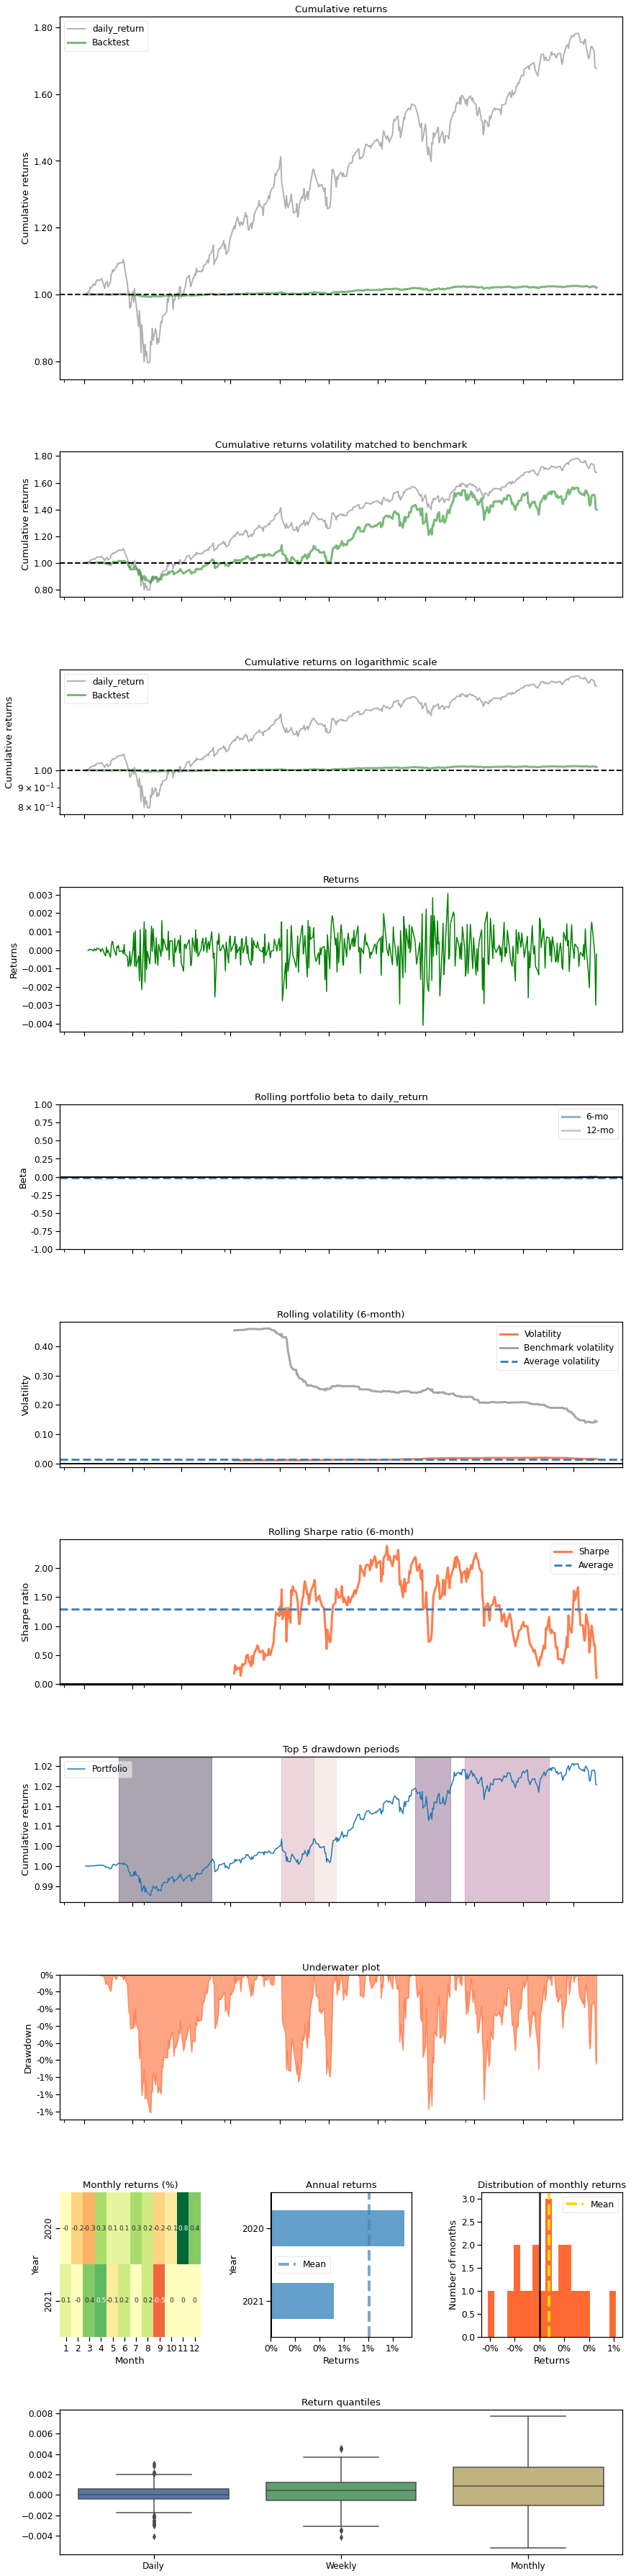

In [ ]:
# Model 1: A2C (Stop Loss Env)
print("==========Compare A2C To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_a2c, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_a2c.loc[0,'date'],
              baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare PPO To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



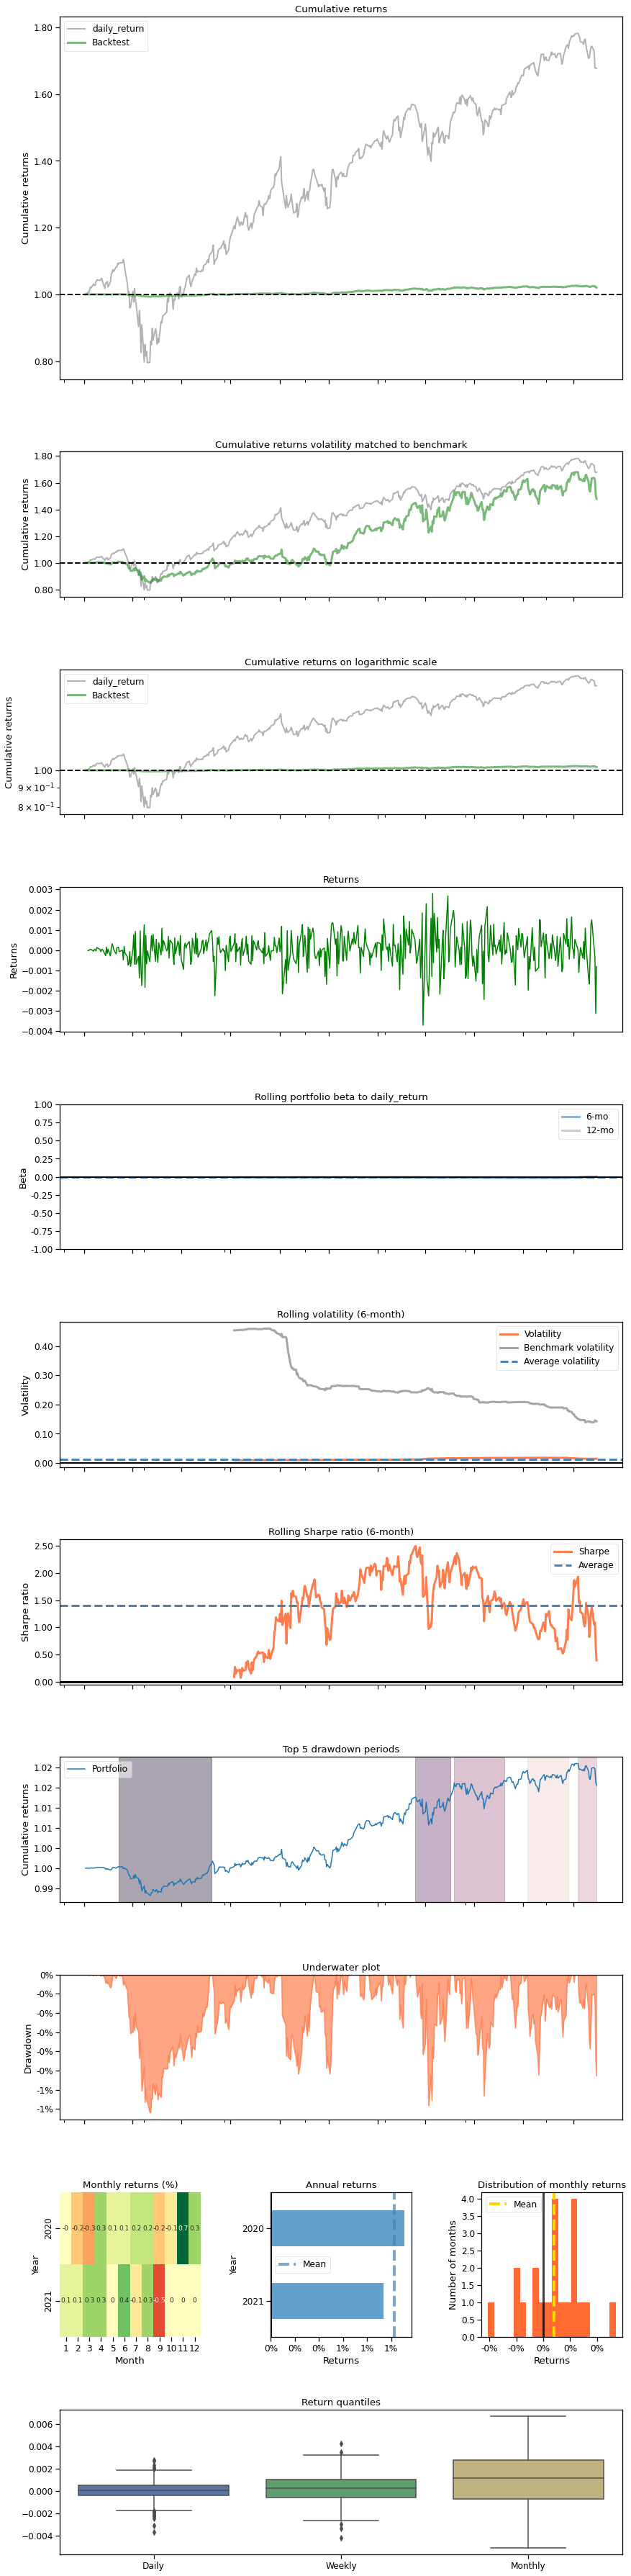

In [ ]:
# Model 2: PPO (Stop Loss Env)
print("==========Compare PPO To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ppo, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ppo.loc[0,'date'],
              baseline_end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare DDPG To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



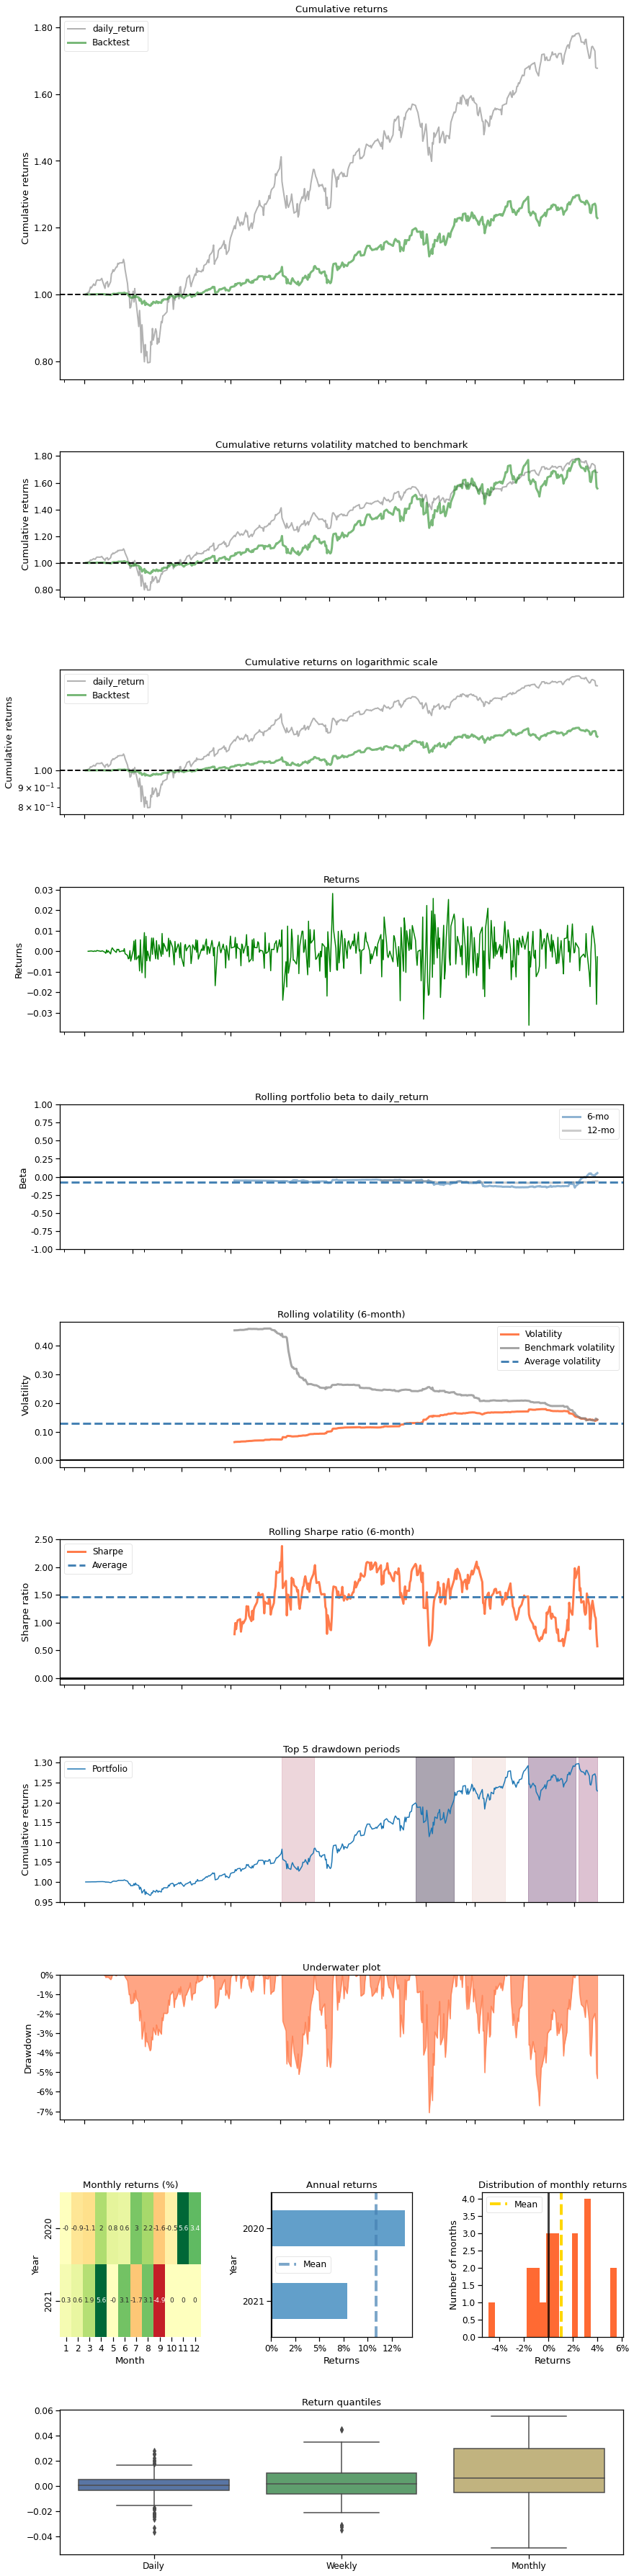

In [ ]:
# Model 3: DDPG (Stop Loss Env)
print("==========Compare DDPG To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_ddpg, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_ddpg.loc[0,'date'],
              baseline_end = df_account_value_ddpg.loc[len(df_account_value_ddpg)-1,'date'],
              value_col_name = 'total_assets')

==========Compare TD3 To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



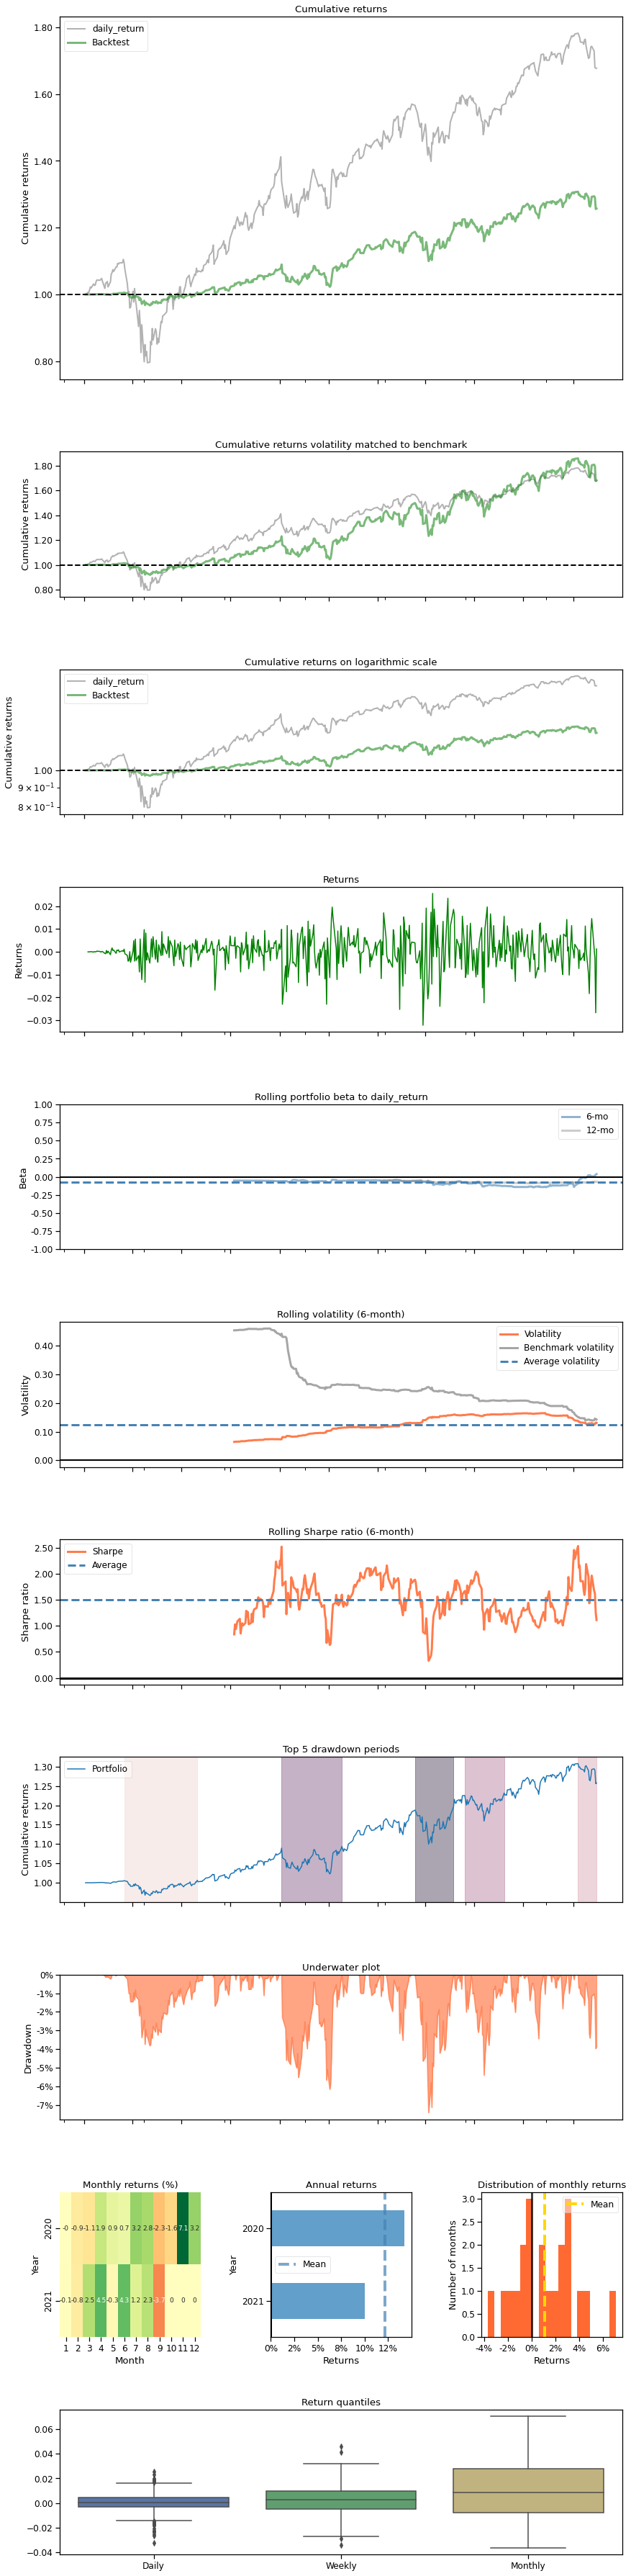

In [ ]:
# Model 4: TD3 (Stop Loss Env)
print("==========Compare TD3 To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_td3, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_td3.loc[0,'date'],
              baseline_end = df_account_value_td3.loc[len(df_account_value_td3)-1,'date'], 
              value_col_name = 'total_assets')

==========Compare SAC To Benchmark==========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (439, 8)


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



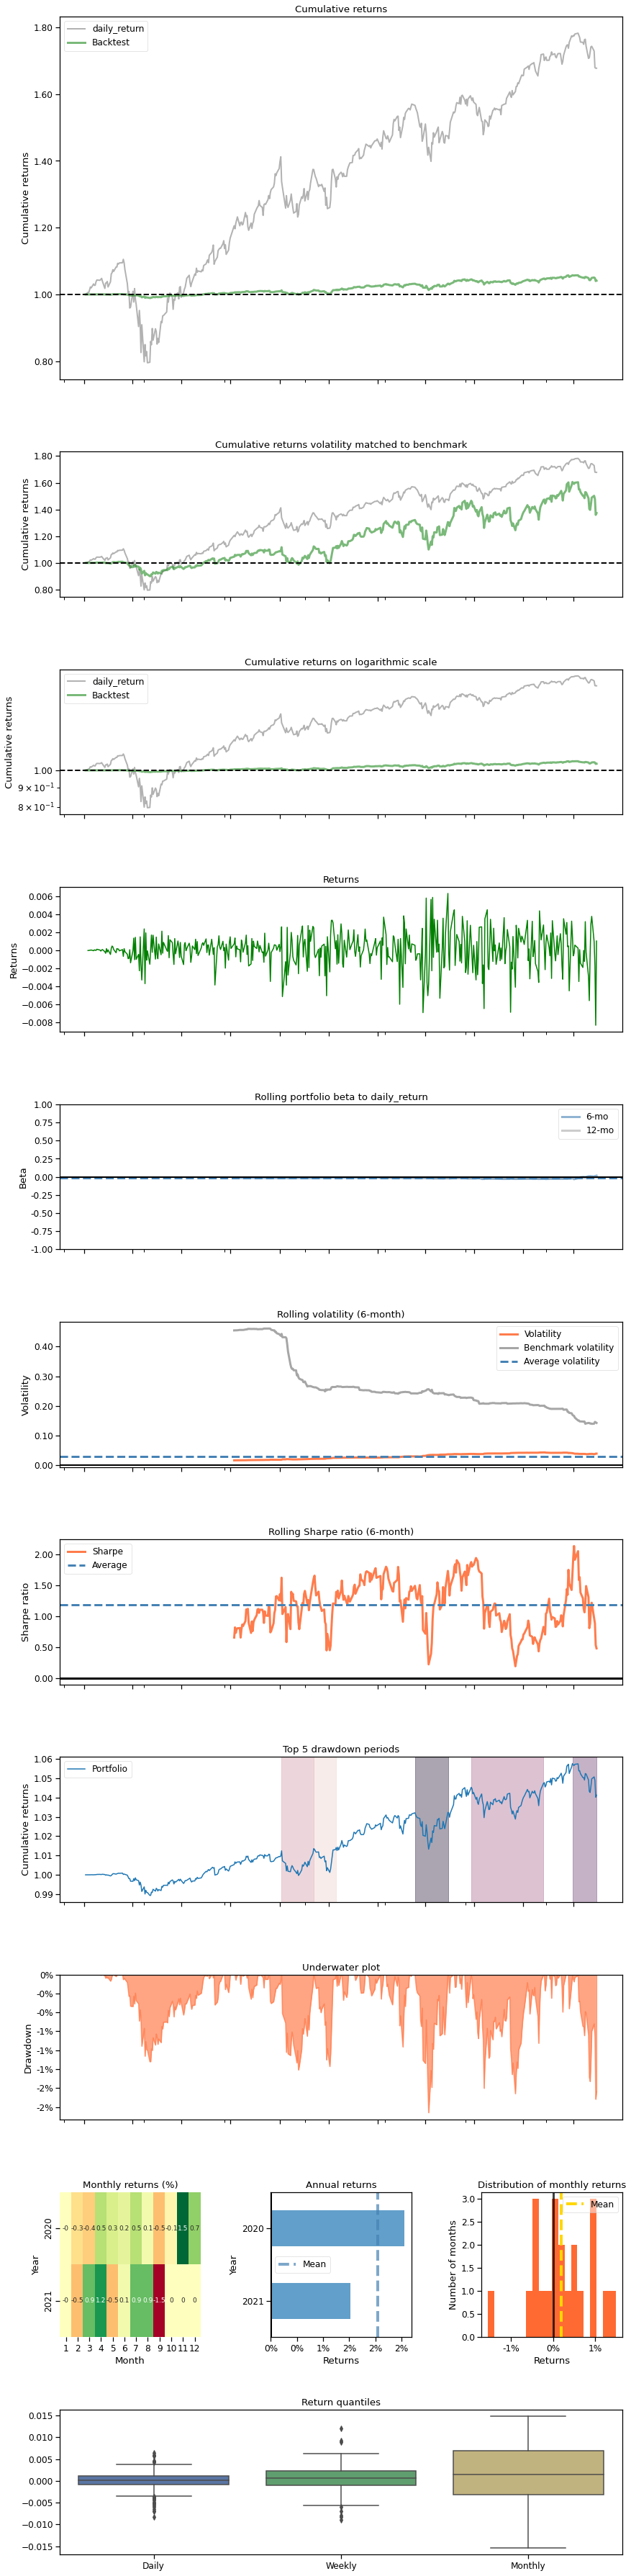

In [ ]:
# Model 5: SAC (Stop Loss Env)
print("==========Compare SAC To Benchmark==========")
%matplotlib inline
backtest_plot(df_account_value_sac, 
              baseline_ticker = 'NDX', 
              baseline_start = df_account_value_sac.loc[0,'date'],
              baseline_end = df_account_value_sac.loc[len(df_account_value_sac)-1,'date'], 
              value_col_name = 'total_assets')